# 01 - Training, Validation, Testing

We are at the moment only testing our accuracy on our test data after we submit it to Kaggle.

Submissions to Kaggle are limited, so we should rather try to test on our training data already.

What we want is to split the train data into:

1. a set we want to train on
2. a set we use only for validating our training

Let's start out with a validation set of size  **1/3**

In [11]:
%load_ext autoreload
%autoreload 2


import tools.extract as ex
import tools.transform as tr

train, test = ex.load("data")

DATA_SIZE = len(train)
VALIDATION_SIZE = int(len(train) * 1/8)
TRAIN_SIZE = DATA_SIZE - VALIDATION_SIZE

from sklearn.utils import shuffle

shuffled = shuffle(train)

validation_set = shuffled [ TRAIN_SIZE: ]
training_set = shuffled [ :TRAIN_SIZE ]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import tools.extract as ex
import tools.transform as tr

# 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
# 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'

features = ['Pclass', 'Sex', 'Age']

def transform(data):
    selected = tr.select(data, features)
    selected["Sex"], _ = ( tr.encode_categories( selected, "Sex" ))
    selected["Age"] = tr.set_NaN(selected, "Age", 0)
    return selected

import tools.classifiers.decision_tree as dt
import tools.predict as p

labels = training_set['Survived']

tree = dt.DecisionTree(features)
p.train(tree, transform(training_set), labels)

val_predictions = p.predict(tree, transform(validation_set))
train_predictions = p.predict(tree, transform(training_set))

ID = "PassengerId"
LABEL = "Survived"

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [13]:
def accuracy( predicted, ground_truth, printf = False ):
    correct = (predicted == ground_truth).sum()
    if printf:
        print( "correct/total: " + str(correct) +"/"+ str(len(predicted)))
        print( "accuracy: " + str(correct/len(predicted)) )
    return correct/len(predicted)

print("Training data:")
accuracy(train_predictions, training_set['Survived'], printf = True)
print("\n\nValidation data:")
accuracy(val_predictions, validation_set['Survived'], printf = True)

Training data:
correct/total: 689/780
accuracy: 0.883333333333


Validation data:
correct/total: 90/111
accuracy: 0.810810810811


0.81081081081081086

## Cool! Now we are set to rumble!

Let us try different depth limitations for the tree

In [14]:
max_depths = list(range(1,30))

training_acc = []
validation_acc = []

for i in max_depths:
    tree = dt.DecisionTree(features, max_depth = i)
    p.train(tree, transform(training_set), training_set['Survived'])

    val_predictions = p.predict(tree, transform(validation_set))
    train_predictions = p.predict(tree, transform(training_set))
    
    print("Max Depth: " + str(i))
    print("Training data:")
    training_acc.append(accuracy(train_predictions, training_set['Survived'], printf = True))
    print("\n\nValidation data:")
    validation_acc.append(accuracy(val_predictions, validation_set['Survived'], printf = True))
    
    print("\n----------------")


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Max Depth: 1
Training data:
correct/total: 612/780
accuracy: 0.784615384615


Validation data:
correct/total: 89/111
accuracy: 0.801801801802

----------------
Max Depth: 2
Training data:
correct/total: 615/780
accuracy: 0.788461538462


Validation data:
correct/total: 86/111
accuracy: 0.774774774775

----------------
Max Depth: 3
Training data:
correct/total: 621/780
accuracy: 0.796153846154


Validation data:
correct/total: 90/111
accuracy: 0.810810810811

----------------
Max Depth: 4
Training data:
correct/total: 623/780
accuracy: 0.798717948718


Validation data:
correct/total: 90/111
accuracy: 0.810810810811

----------------
Max Depth: 5
Training data:
correct/total: 645/780
accuracy: 0.826923076923


Validation data:
correct/total: 89/111
accuracy: 0.801801801802

----------------
Max Depth: 6
Training data:
correct/total: 647/780
accuracy: 0.829487179487


Validation data:
correct/total: 88/111
accuracy: 0.792792792793

----------------
Max Depth: 7
Training data:
correct/tota

## Okay interesting... 

but now let's plot it to see how the training accuracy and the validation accuracy behave with respect to the maximum tree depth

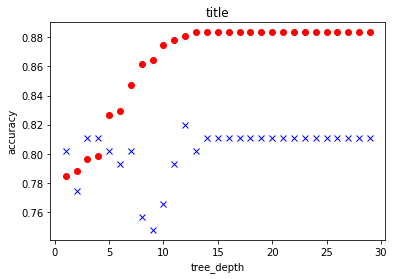

In [15]:
from pylab import *
import matplotlib.pyplot as plt

figure()
plt.plot(max_depths, training_acc, 'o', color='red')
plt.plot(max_depths, validation_acc, 'x', color='blue')

plt.xlabel('tree_depth')
plt.ylabel('accuracy')
plt.title('title')
plt.show()

As we can see best tree depth for the validation set is actually already at 7

## Problem
This highly depends on how we choose the validation set. If we resample the validation set and choose a different values, the plot changes for the validation accuracy

**Instead ..**

We can do k-fold cross validation. That means:
1. we split all the given data in k different sets.
2. for each set
    - we use that sets for validation
    - we use the rest for the training
    - we calculate the accuracy on the validation set
3. take the average over all the calculated accuracy
4. plot

**Hopefully the result will be a bit more stable!**

## Let's try 5 fold cross validation here!

In [16]:
def get_k_splits(data, k):
    
    splits = []
    
    SPLIT_SIZE = round(len(data)/k)
    end_index = 0
    
    for i in range(k - 1):
        
        start_index = end_index
        end_index += SPLIT_SIZE
        
        splits.append( (start_index,end_index) )
    
    splits.append( ( end_index, len(data)) )
    
    return splits

train, test = ex.load("data")

splits = get_k_splits(train, 5)

splits

[(0, 178), (178, 356), (356, 534), (534, 712), (712, 891)]

## Now all we need to do is iterate through those 5 splits and validate

In [18]:
def cross_validation_accuracy(data, kfold, max_depth, printf=False):
    
    splits = get_k_splits(data, kfold)
    training_acc = []
    validation_acc = []
    
    for s in splits:        
        validation_set = data[ s[0]: s[1] ]
        if not data[0:s[0]].empty:
            training_set = data[0: s[0]].append(data[s[1]:len(data)])
        else:
            training_set = data[s[1]:len(data)]
        
        tree = dt.DecisionTree(features, max_depth = max_depth)
        p.train(tree, transform(training_set), training_set["Survived"])

        val_predictions = p.predict(tree, transform(validation_set))
        train_predictions = p.predict(tree, transform(training_set))
    
        training_acc.append(accuracy(train_predictions, training_set['Survived']))
        validation_acc.append(accuracy(val_predictions, validation_set['Survived']))
    
    t_acc = sum(training_acc)/len(training_acc)
    v_acc = sum(validation_acc)/len(validation_acc)
    
    if printf:
        print("AVG training acc: \t" + str(t_acc))
        print("AVG validation acc: \t" + str(v_acc))

    return t_acc, v_acc
from sklearn.utils import shuffle

shuffle(train)
cross_validation_accuracy(shuffle(train), 2, 3, printf=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


AVG training acc: 	0.80583715423
AVG validation acc: 	0.791250566836


(0.80583715422985835, 0.79125056683629769)

In [19]:
max_depths = list(range(1,15))

training_history = []
validation_history = []

training_set, _ = ex.load("data")

for i in max_depths:
    print("Max Depth: " + str(i))
    training_acc, validation_acc = cross_validation_accuracy(training_set, 5, i, printf=True)
    training_history.append( training_acc )
    validation_history.append( validation_acc )
    
    print("\n----------------")

Max Depth: 1


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


AVG training acc: 	0.786755598279
AVG validation acc: 	0.577754064403

----------------
Max Depth: 2
AVG training acc: 	0.790121657185
AVG validation acc: 	0.564270918335

----------------
Max Depth: 3
AVG training acc: 	0.80106450037
AVG validation acc: 	0.592348251836

----------------
Max Depth: 4
AVG training acc: 	0.811726838647
AVG validation acc: 	0.603609315172

----------------
Max Depth: 5
AVG training acc: 	0.824912145232
AVG validation acc: 	0.596848910928

----------------
Max Depth: 6
AVG training acc: 	0.8364152103
AVG validation acc: 	0.586749105518

----------------
Max Depth: 7
AVG training acc: 	0.849887325275
AVG validation acc: 	0.651879982424

----------------
Max Depth: 8
AVG training acc: 	0.860548875617
AVG validation acc: 	0.621561734982

----------------
Max Depth: 9
AVG training acc: 	0.869246891596
AVG validation acc: 	0.626049839935

----------------
Max Depth: 10
AVG training acc: 	0.875419575461
AVG validation acc: 	0.620431862407

----------------
Max D

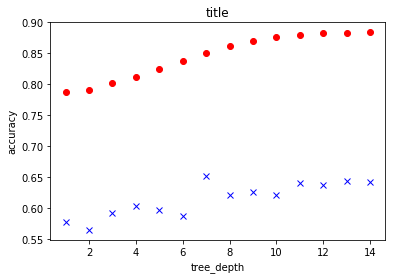

In [21]:
figure()
plt.plot(max_depths, training_history, 'o', color='red')
plt.plot(max_depths, validation_history, 'x', color='blue')

plt.xlabel('tree_depth')
plt.ylabel('accuracy')
plt.title('title')

plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


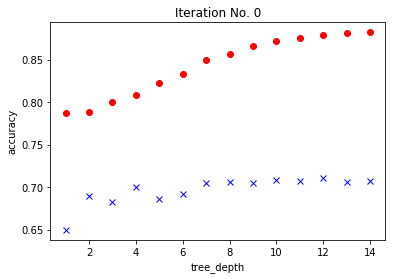

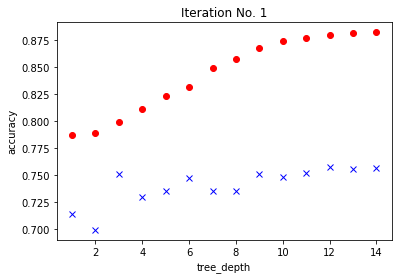

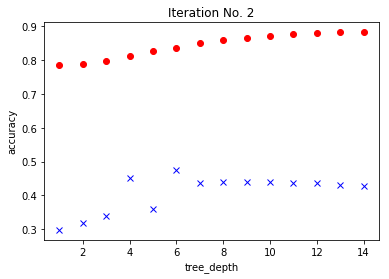

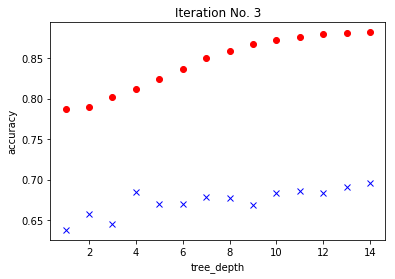

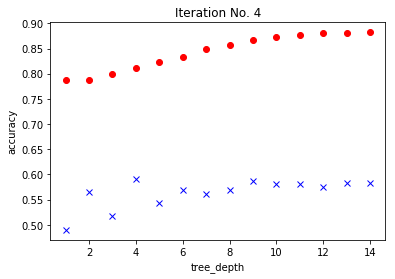

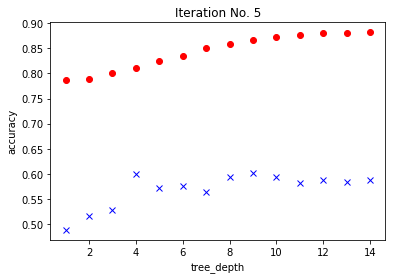

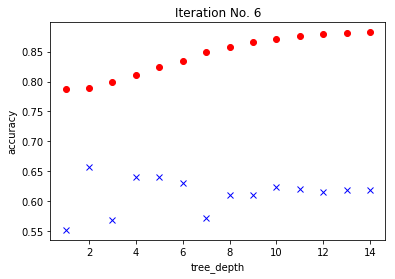

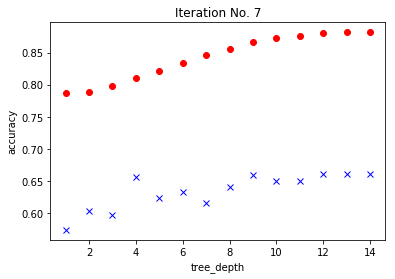

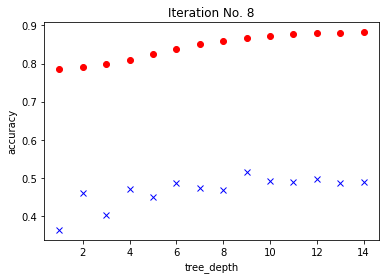

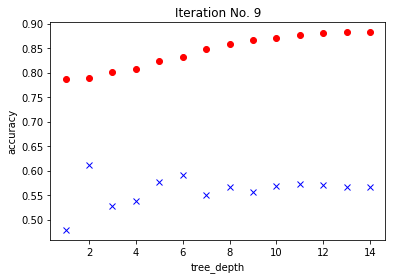

In [22]:
def run(it):
    max_depths = list(range(1,15))

    training_history = []
    validation_history = []

    training_set, _ = ex.load("data")
    
    from sklearn.utils import shuffle
    training_set = shuffle(training_set)

    for i in max_depths:
        training_acc, validation_acc = cross_validation_accuracy(training_set, 8, i)
        training_history.append( training_acc )
        validation_history.append( validation_acc )

    figure()
    plt.plot(max_depths, training_history, 'o', color='red')
    plt.plot(max_depths, validation_history, 'x', color='blue')

    plt.xlabel('tree_depth')
    plt.ylabel('accuracy')
    plt.title('Iteration No. ' + str(it))

for i in range(0,10):
    run(i)
plt.show()

### Not the best results, but at least now we can reconstruct the majority of our curves to a certain extent.

Our classifier is still pretty bad.

# Next Step: Try learning with more features!

But first let's submit a prediction where we only define a tree depth of 6

In [26]:
train, test = ex.load("data")

ID = "PassengerId"
LABEL = "Survived"

tree = dt.DecisionTree(features, max_depth=6)
p.train(tree, transform(train), train[LABEL])
predictions = p.predict(tree, transform(test))


p.save( "01.csv", [ID, LABEL], test[ID], predictions)

Saved file: 01.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
